# Descriptive title that follows notebook filename <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with the `NCI`|`DEA Sandbox` environment only
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule),
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** An _optional_ description of any special requirements, e.g. If running on the [NCI](https://nci.org.au/), ensure that `module load otps` is run prior to launching this notebook
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook


## Background
An *optional* overview of the scientific, economic or environmental management issue or challenge being addressed by Digital Earth Australia. 
For `Beginners_Guide` or `Frequently_Used_Code` notebooks, this may include information about why the particular technique or approach is useful or required. 
If you need to cite a scientific paper or link to a website, use a persistent DOI link if possible and link in-text (e.g. [Dhu et al. 2017](https://doi.org/10.1080/20964471.2017.1402490)).

## Description
A _compulsory_ description of the notebook, including a brief overview of how Digital Earth Australia helps to address the problem set out above.
It can be good to include a run-down of the tools/methods that will be demonstrated in the notebook:

1. First we do this
2. Then we do this
3. Finally we do this

***

## Getting started

Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. 
Begin with any `iPython` magic commands, followed by standard Python packages, then any additional functionality you need from the `Scripts` directory.

In [14]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import xarray as xr

sys.path.append('../Scripts')
from dea_plotting import rgb

from datacube import Datacube
from odc.algo import fmask_to_bool, to_f32, from_float, xr_geomedian


In [6]:
# !pip install --user --extra-index-url="https://packages.dea.ga.gov.au" hdstats
# !pip install --user --extra-index-url="https://packages.dea.ga.gov.au" odc-algo

In [7]:
from datacube.utils.rio import configure_s3_access
from datacube.utils.dask import start_local_dask
import os
import dask
from dask.utils import parse_bytes

# configure dashboard link to go over proxy
dask.config.set({"distributed.dashboard.link":
                 os.environ.get('JUPYTERHUB_SERVICE_PREFIX', '/')+"proxy/{port}/status"});

# Figure out how much memory/cpu we really have (those are set by jupyterhub)
mem_limit = int(os.environ.get('MEM_LIMIT', '0'))
cpu_limit = float(os.environ.get('CPU_LIMIT', '0'))
cpu_limit = int(cpu_limit) if cpu_limit > 0 else 4
mem_limit = mem_limit if mem_limit > 0 else parse_bytes('8Gb')

# leave 4Gb for notebook itself
mem_limit -= parse_bytes('4Gb')

# close previous client if any, so that one can re-run this cell without issues
client = locals().get('client', None)
if client is not None:
    client.close()
    del client
    
client = start_local_dask(n_workers=1,
                          threads_per_worker=cpu_limit, 
                          memory_limit=mem_limit)
display(client)

# Configure GDAL for s3 access 
configure_s3_access(aws_unsigned=True,  # works only when reading public resources
                    client=client);

Client Scheduler: tcp://127.0.0.1:33905 Dashboard: /user/robbibt/proxy/8787/status,Cluster Workers: 1 Cores: 8 Memory: 60.42 GB


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [8]:
dc = datacube.Datacube(app='DEA_notebooks_template')

### Analysis parameters

An *optional* section to inform the user of any parameters they'll need to configure to run the notebook:

* `param_name_1`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.
* `param_name_2`: Simple description (e.g. `example_value`). Advice about appropriate values to choose for this parameter.


In [92]:
from odc.ui import select_on_a_map
from datacube.utils.geometry import CRS

geopolygon = select_on_a_map(height='600px', 
                             center=(-27.37, 153.48),
                             zoom=12)

# Test size
area = geopolygon.to_crs(crs = CRS('epsg:3577')).area / 10000000
if area > 100: 
    print(f'Warning: Your selected area is {area:.00f} square kilometers. \n'
          f'An area of less than 100 square kilometers (e.g. 10 x 10 km) is '
          f'recommended. \nTo select a smaller area, re-run the cell above '
          f'and draw a new polygon.')


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

An area of less than 100 square kilometers (e.g. 10 x 10 km) is recommended. 
To select a smaller area, re-run the cell above and draw a new polygon.


In [ ]:
# query = {'time': ('2010', '2019'),
#          'geopolygon': geopolygon}

# from datacube.virtual import catalog_from_file
# catalog = catalog_from_file('../MAHTS/MAHTS_virtual_products.yaml')
# product = catalog['ls_nbart_masked']

# ds = product.load(dc, **query)

In [93]:
from dea_datahandling import load_ard

query = {'time': ('2010', '2019'),
         'geopolygon': geopolygon,
         'output_crs': 'epsg:3577',
         'resampling': {'*': 'average', 'fmask': 'nearest'},
         'resolution': (-30, 30)}

# ds = load_ard(dc=dc, 
#               measurements=['nbart_blue', 'nbart_green', 'nbart_red'],  #, 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
#               min_gooddata=0.7,
#               products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], 
#               **query)

ds = dc.load(product='ga_ls8c_ard_3',
        measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'fmask'],
        group_by='solar_day',
        dask_chunks=dict(x=1000, y=1000),     
        **query)

xx_data = ds[['nbart_blue', 'nbart_green', 'nbart_red']]

In [94]:
scale, offset = (1/10_000, 0)  # differs per product, aim for 0-1 values in float32

# no_cloud = fmask_to_bool(ds.fmask, ('valid', 'snow', 'water'))
no_cloud = ds.fmask.isin([1, 4, 5])

xx_clean = odc.algo.keep_good_only(xx_data, where=no_cloud)
xx_clean = to_f32(xx_clean, scale=scale, offset=offset)
# yy = xr_geomedian(xx_clean, 
#                   num_threads=1,  # disable internal threading, dask will run several concurrently
#                   eps=0.2*scale,  # 1/5 pixel value resolution
#                   nocheck=True)   # disable some checks inside geomedian library that use too much ram

# yy = from_float(yy, 
#                 dtype='int16', 
#                 nodata=-999, 
#                 scale=1/scale, 
#                 offset=-offset/scale)

In [95]:
yy = xx_clean.resample(time='2Y').apply(lambda x: xr_geomedian(x, 
                  num_threads=1,  # disable internal threading, dask will run several concurrently
                  eps=0.2*scale,  # 1/5 pixel value resolution
                  nocheck=True))

In [96]:
%%time
yy = yy.compute()

CPU times: user 53.4 s, sys: 2.99 s, total: 56.4 s
Wall time: 5min 16s


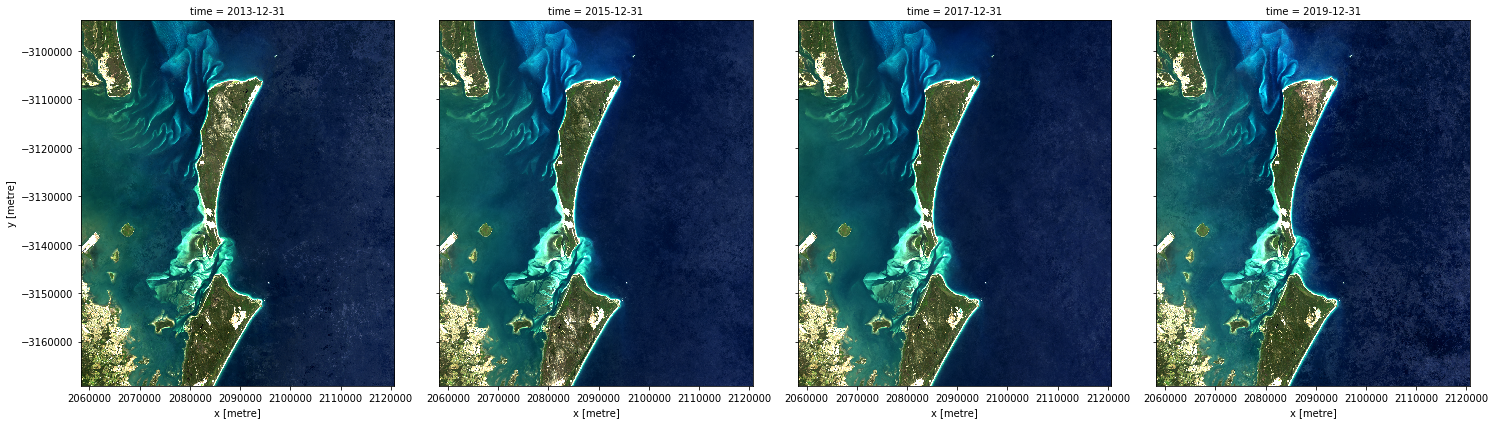

In [97]:
rgb(yy, col='time')

/usr/local/lib/python3.6/dist-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


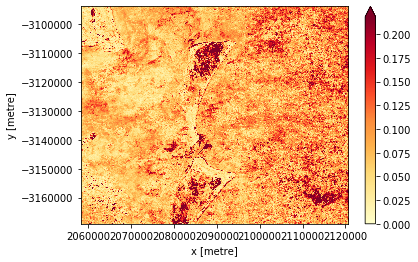

In [102]:
(np.log(yy.to_array())).std(dim=['time']).mean(dim='variable').plot.imshow(robust=True, cmap='YlOrRd', vmin=0)

In [103]:
yy

<xarray.Dataset>
Dimensions:      (time: 4, x: 2082, y: 2513)
Coordinates:
  * time         (time) datetime64[ns] 2013-12-31 2015-12-31 ... 2019-12-31
  * y            (y) float64 -3.094e+06 -3.094e+06 ... -3.169e+06 -3.169e+06
  * x            (x) float64 2.058e+06 2.058e+06 ... 2.121e+06 2.121e+06
Data variables:
    nbart_blue   (time, y, x) float32 0.024535256 0.028832655 ... 0.046666708
    nbart_green  (time, y, x) float32 0.03300505 0.037702158 ... 0.030925168
    nbart_red    (time, y, x) float32 0.035339955 0.038371827 ... 0.024675203

In [6]:
# pip install --user --extra-index-url="https://packages.dea.ga.gov.au" hdstats
from hdstats import nangeomedian_pcm
import dask

def reshape_for_geomedian(ds, axis='time'):
    dims = set(v.dims for v in ds.data_vars.values())
    if len(dims) != 1:
        raise ValueError("All bands should have same dimensions")

    dims = dims.pop()
    if len(dims) != 3:
        raise ValueError("Expect 3 dimensions on input")

    if axis not in dims:
        raise ValueError(f"No such axis: {axis}")

    dims = tuple(d for d in dims if d != axis) + ('band', axis)

    nodata = set(getattr(v, 'nodata', None) for v in ds.data_vars.values())
    if len(nodata) == 1:
        nodata = nodata.pop()
    else:
        nodata = None

    # xx: {y, x}, band, time
    xx = ds.to_array(dim='band').transpose(*dims)

    if nodata is not None:
        xx.attrs.update(nodata=nodata)

    return xx

def xr_geomedian(ds, axis='time', where=None, **kwargs):
    """

    :param ds: xr.Dataset|xr.DataArray|numpy array

    Other parameters:
    **kwargs -- passed on to pcm.gnmpcm
       maxiters   : int         1000
       eps        : float       0.0001
       num_threads: int| None   None
    """

    def norm_input(ds, axis):
        if isinstance(ds, xr.DataArray):
            xx = ds
            if len(xx.dims) != 4:
                raise ValueError("Expect 4 dimensions on input: y,x,band,time")
            if axis is not None and xx.dims[3] != axis:
                raise ValueError(f"Can only reduce last dimension, expect: y,x,band,{axis}")
            return None, xx, xx.data
        elif isinstance(ds, xr.Dataset):
            xx = reshape_for_geomedian(ds, axis)
            return ds, xx, xx.data
        else:  # assume numpy or similar
            xx_data = ds
            if xx_data.ndim != 4:
                raise ValueError("Expect 4 dimensions on input: y,x,band,time")
            return None, None, xx_data

    ds, xx, xx_data = norm_input(ds, axis)
    is_dask = dask.is_dask_collection(xx_data)

    if where is not None:
        if is_dask:
            raise NotImplementedError("Dask version doesn't support output masking currently")

        if where.shape != xx_data.shape[:2]:
            raise ValueError("Shape for `where` parameter doesn't match")
        set_nan = ~where
    else:
        set_nan = None

    if is_dask:
        if xx_data.shape[-2:] != xx_data.chunksize[-2:]:
            xx_data = xx_data.rechunk(xx_data.chunksize[:2] + (-1, -1))

        data = da.map_blocks(lambda x: nangeomedian_pcm(x, **kwargs),
                             xx_data,
                             name='geomedian',
                             dtype=xx_data.dtype,
                             drop_axis=3)
    else:
        data = nangeomedian_pcm(xx_data, **kwargs)

    if set_nan is not None:
        data[set_nan, :] = np.nan

    if xx is None:
        return data

    dims = xx.dims[:-1]
    cc = {k: xx.coords[k] for k in dims}
    xx_out = xr.DataArray(data, dims=dims, coords=cc)

    if ds is None:
        xx_out.attrs.update(xx.attrs)
        return xx_out

    ds_out = xx_out.to_dataset(dim='band')
    for b in ds.data_vars.keys():
        src, dst = ds[b], ds_out[b]
        dst.attrs.update(src.attrs)

    return ds_out

In [7]:
test = ds.resample(time='2y', closed='left', label='right').apply(xr_geomedian)
test.attrs['crs'] = ds.crs
test

Automatically using 16 threads.
Automatically using 16 threads.
Automatically using 16 threads.
Automatically using 16 threads.


<xarray.Dataset>
Dimensions:       (time: 4, x: 234, y: 243)
Coordinates:
  * time          (time) datetime64[ns] 2014-12-31 2016-12-31 ... 2020-12-31
  * y             (y) float64 -3.14e+06 -3.14e+06 ... -3.147e+06 -3.147e+06
  * x             (x) float64 2.082e+06 2.082e+06 ... 2.089e+06 2.089e+06
Data variables:
    nbart_blue    (time, y, x) float32 276.49472 266.77942 ... 413.00003
    nbart_green   (time, y, x) float32 383.18204 377.15057 ... 292.74863 284.0
    nbart_red     (time, y, x) float32 367.06485 355.10483 ... 110.999985
    nbart_nir     (time, y, x) float32 433.70975 450.9754 ... 121.99997
    nbart_swir_1  (time, y, x) float32 103.91319 116.420654 ... 74.00007
    nbart_swir_2  (time, y, x) float32 66.50328 73.86798 ... 74.88305 91.999916
Attributes:
    crs:      epsg:3577

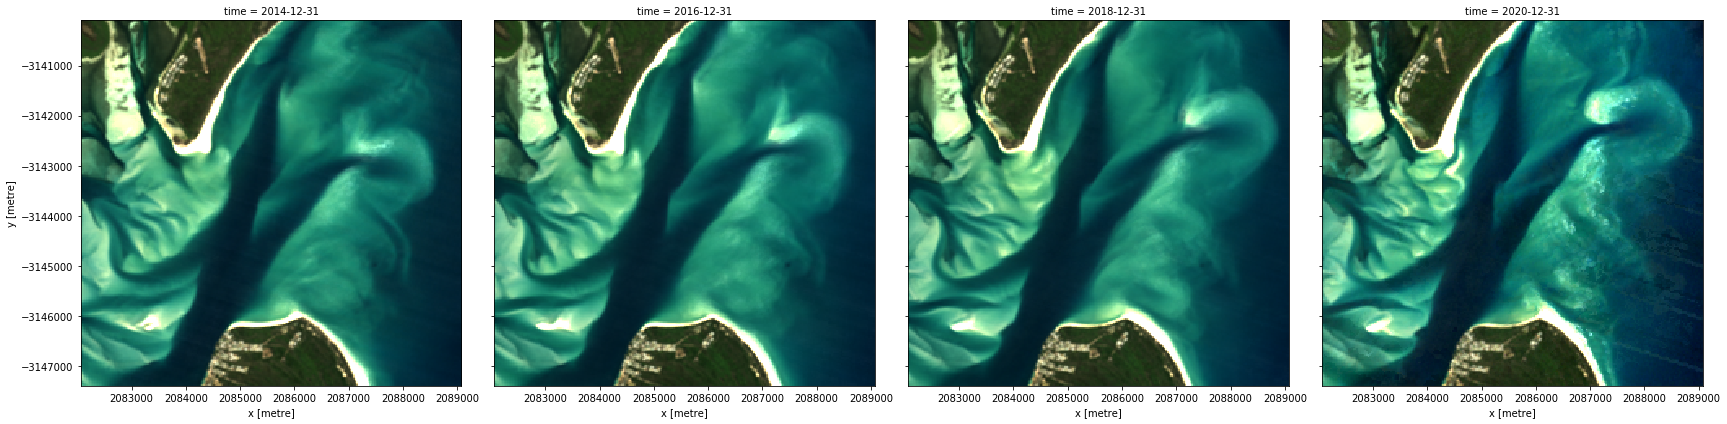

In [8]:
rgb(test, col='time')  # bands=['nbart_red', 'green', 'blue'], 
# test[['red', 'green', 'blue']].to_array().plot.imshow(col='time', robust=True)

In [ ]:

# from datacube.helpers import write_geotiff

# write_geotiff


# test.groupby('time').apply(lambda x: print(x)) #write_geotiff(filename='test.tif', dataset=x))

In [ ]:
# [write_geotiff(filename=f'{str(i)[0:10]}.tif', dataset=ds) for i, ds in test.groupby('time')]

In [ ]:
(np.log(test[['nbart_red', 'nbart_green', 'nbart_blue']].to_array())).std(dim=['time']).mean(dim='variable').plot.imshow(robust=True, cmap='YlOrRd', vmin=0)

## Heading 1
Use headings to break up key steps/stages of the notebook.

Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.

> **Note:** Use this markdown format (sparingly) to draw particular attention to an important point or caveat

In [ ]:
# Use code comments for low-level documentation of code
a = 1

### Subheading 1
Use subheadings to break up steps within a single section.

In [ ]:
# Use code comments for low-level documentation of code
b = 2

## Heading 2
Use markdown text for detailed, descriptive text explaining what the code below does and why it is needed.

In [ ]:
# Use code comments for low-level documentation of code
c = 3

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)